# リポジトリクローン

In [ ]:
!git clone https://github.com/ZhengPeng7/BiRefNet.git
%cd BiRefNet

# パッケージインストール

In [ ]:
!pip uninstall -q torchaudio torchdata torchtext -y
!pip install -q -r requirements.txt
!pip install onnx onnxruntime

# 重みダウンロード

In [ ]:
!wget https://github.com/ZhengPeng7/BiRefNet/releases/download/v1/BiRefNet-general-epoch_244.pth

# モデルロード

In [4]:
import torch
from utils import check_state_dict
from models.birefnet import BiRefNet

birefnet = BiRefNet(bb_pretrained=False)
state_dict = torch.load('BiRefNet-general-epoch_244.pth', map_location='cpu')
state_dict = check_state_dict(state_dict)
birefnet.load_state_dict(state_dict)

torch.set_float32_matmul_precision(['high', 'highest'][0])

birefnet.to('cpu')
_ = birefnet.eval()

# ONNX変換時のdeform_conv2d対応

In [5]:
!git clone https://github.com/masamitsu-murase/deform_conv2d_onnx_exporter
%cp deform_conv2d_onnx_exporter/src/deform_conv2d_onnx_exporter.py .

Cloning into 'deform_conv2d_onnx_exporter'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (7/7), done.
remote: Total 205 (delta 6), reused 6 (delta 6), pack-reused 198 (from 1)
Receiving objects: 100% (205/205), 36.21 KiB | 1.17 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [6]:
# _get_tensor_dim_size()エラー暫定対応
with open('deform_conv2d_onnx_exporter.py') as fp:
    file_lines = fp.read()

file_lines = file_lines.replace(
    "return sym_help._get_tensor_dim_size(tensor, dim)",
    '''
    tensor_dim_size = sym_help._get_tensor_dim_size(tensor, dim)
    if tensor_dim_size == None and (dim == 2 or dim == 3):
        import typing
        from torch import _C

        x_type = typing.cast(_C.TensorType, tensor.type())
        x_strides = x_type.strides()

        tensor_dim_size = x_strides[2] if dim == 3 else x_strides[1] // x_strides[2]
    elif tensor_dim_size == None and (dim == 0):
        import typing
        from torch import _C

        x_type = typing.cast(_C.TensorType, tensor.type())
        x_strides = x_type.strides()
        tensor_dim_size = x_strides[3]

    return tensor_dim_size
    ''',
)

with open('deform_conv2d_onnx_exporter.py', mode="w") as fp:
    fp.write(file_lines)

# ONNX変換

In [7]:
from torchvision.ops.deform_conv import DeformConv2d
import deform_conv2d_onnx_exporter

# deform_conv2d op登録
deform_conv2d_onnx_exporter.register_deform_conv2d_onnx_op()

def convert_to_onnx(net, file_name='output.onnx', input_shape=(1024, 1024), device='cpu'):
    input = torch.randn(1, 3, input_shape[0], input_shape[1]).to(device)

    input_layer_names = ['input_image']
    output_layer_names = ['temp1', 'temp2', 'temp3', 'output_image']

    torch.onnx.export(
        net,
        input,
        file_name,
        verbose=True,
        opset_version=16,
        input_names=input_layer_names,
        output_names=output_layer_names,
    )

In [8]:
convert_to_onnx(birefnet, 'birefnet_1024x1024.onnx', input_shape=(1024, 1024), device='cpu')

/content/BiRefNet/models/backbones/swin_v1.py:441: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if W % self.patch_size[1] != 0:
/content/BiRefNet/models/backbones/swin_v1.py:443: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if H % self.patch_size[0] != 0:
/content/BiRefNet/models/backbones/swin_v1.py:379: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize t

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



# サンプル画像ダウンロード

In [9]:
!wget https://raw.githubusercontent.com/Kazuhito00/BiRefNet-ONNX-Sample/main/sample.jpg -O sample.jpg

--2024-08-14 02:26:05--  https://user0514.cdnw.net/shared/img/thumb/ZUBDSC_8460_TP_V4.jpg
Resolving user0514.cdnw.net (user0514.cdnw.net)... 139.162.75.187
Connecting to user0514.cdnw.net (user0514.cdnw.net)|139.162.75.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65340 (64K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  63.81K  --.-KB/s    in 0.1s    

2024-08-14 02:26:06 (634 KB/s) - ‘sample.jpg’ saved [65340/65340]



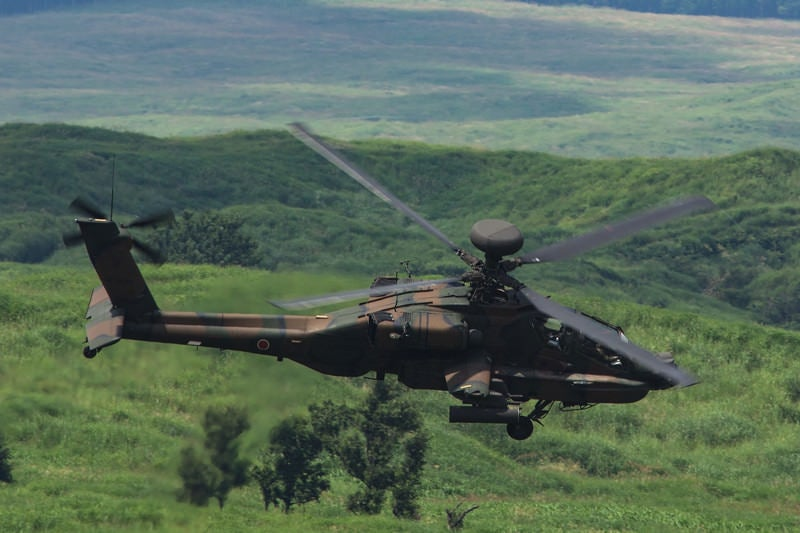

In [11]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('sample.jpg')
image_width, image_height = image.shape[1], image.shape[0]
cv2_imshow(image)

# 推論テスト

In [12]:
import copy
import cv2
import numpy as np
import onnxruntime

# モデルロード
onnx_session = onnxruntime.InferenceSession(
    'birefnet_1024x1024.onnx',
    providers=[
        'CUDAExecutionProvider',
        'CPUExecutionProvider',
    ],
)

# 前処理
input_image = copy.deepcopy(image)
input_image = cv2.resize(input_image, dsize=(1024, 1024))
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
input_image = (input_image / 255 - mean) / std
input_image = input_image.transpose(2, 0, 1).astype('float32')
input_image = input_image.reshape(-1, 3, 1024, 1024)

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [13]:
%%time

# 推論
input_name = onnx_session.get_inputs()[0].name
results = onnx_session.run(None, {input_name: input_image})

CPU times: user 1min 14s, sys: 2.42 s, total: 1min 16s
Wall time: 23.5 s


# 結果確認

In [14]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

In [15]:
# マスク画像
mask_image = np.squeeze(results[-1])
mask_image = sigmoid(mask_image)
mask_image *= 255
mask_image = mask_image.astype('uint8')
mask_image = cv2.resize(mask_image, dsize=(image_width, image_height))

In [16]:
# マスクを元に対象画像を抽出
debug_image = copy.deepcopy(image)

extract_image = np.zeros(debug_image.shape, dtype=np.uint8)
extract_image[:] = (255, 255, 255)
temp_mask_image = np.stack((mask_image, ) * 3, axis=-1).astype('uint8')
extract_image = np.where(temp_mask_image, debug_image, extract_image)

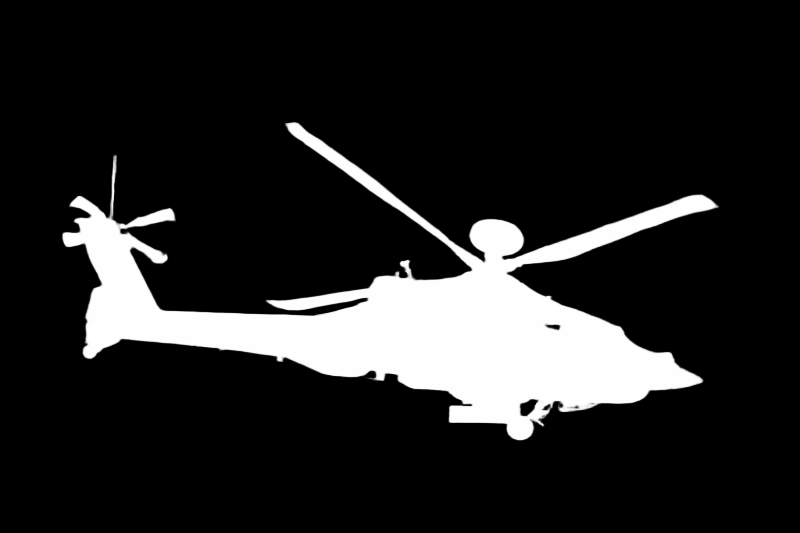

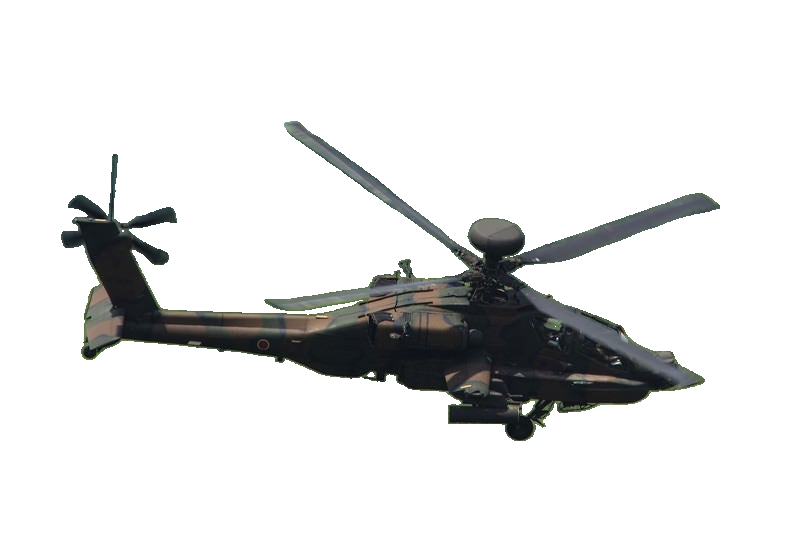

In [17]:
from google.colab.patches import cv2_imshow
cv2_imshow(mask_image)
cv2_imshow(extract_image)